## DZ_7

### Данные:

Датасет разделен на две части: тренировочную (banking_training.csv) и тестовую (banking_test.csv). Используя banking_training.csv происходит тренировка алгоритма, предсказание осуществляется на banking_test.csv.

Описание фичей данных находится в файле banking_desc.csv


### Задача:

Бинарная вероятностная классификация.

Ваша задача спрогнозировать возниконение трудностей у кредитора в течение двух лет (переменная SeriousDlqin2yrs, принимающая значения [0,1]). Также необходимо спрогнозировать вероятность для данной переменной SeriousDlqin2yrs.

Алгоритм для выполнения задачи можно выбирать любой.

### Ход работы:

1. Провести первичный анализ данных: описательные статистики, распределения, наличия пропущенных значений.

2. Осуществить препроцессинг и подготовку данных: выбрать стратегию работы с пропущенными значениями, при необходимости осуществить генерацию дополнительных фичей (пояснить логику). 

3. Провести корреляционный анализ и проверить выбор дополнительных фичей в сете.

4. Отобрать фичи для построения модели используя подход Wrapper methods или любой из методов Univariate Feature Selection (к примеру SelectKBest или SelectPercentile).

5. Протестировать на тренировочном дата сете различные наборы фичей и их работу с выбранными алгоритмами для осуществления предсказания.

6. Выбрать лучший набор фичей и лучший алгоритм для осуществленния как предсказания классов так и вероятности. Провести сравнение на тестовой выборке используя следующие метрики для оценки качества алгоритма: 

    -Классификация: Accuracy Score, f1-Score, Precision, Recall
    
    -Вероятность: log_loss Score    
    


In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE, SVMSMOTE, BorderlineSMOTE

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")

In [104]:
rs = 0

In [105]:
data = pd.read_csv('banking_train.csv', delimiter=',')
data = data.drop(data.columns[0], axis=1)
data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.114987,62,0,1841.000000,NaN,5,0,1,0,2.0
1,0,0.008705,73,0,0.498553,3800.0,6,0,1,0,0.0
2,0,0.214501,32,0,0.211999,3716.0,8,0,0,0,2.0
3,0,1.000000,60,0,118.000000,NaN,5,0,0,0,0.0
4,0,0.230493,60,0,1.017328,3000.0,10,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
119995,0,0.004136,41,0,0.472323,7695.0,9,0,2,0,0.0
119996,0,0.000000,49,0,0.322344,8583.0,18,0,1,0,1.0
119997,0,1.000000,80,0,35.000000,NaN,0,0,0,0,0.0
119998,0,0.925187,63,0,0.389974,1535.0,2,1,0,0,0.0


In [106]:
Y = data['SeriousDlqin2yrs']
X = data.drop('SeriousDlqin2yrs', axis = 1)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=rs)

In [108]:
def prepare_data(x, y):
    temp = pd.concat([x, y], axis = 1)
    
    temp = temp[temp['age'] > 0]
    temp = temp[temp['MonthlyIncome'] > 0]
    temp = temp[temp['RevolvingUtilizationOfUnsecuredLines'] < 100]
    temp['NumberOfDependents'].fillna(0, inplace = True)
    
    cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
    
    temp['wasoverdue'] = 0
    
    for i in temp.index:
        if temp[cols[0]][i] > 0 or \
           temp[cols[1]][i] > 0 or \
           temp[cols[2]][i] > 0:
             temp['wasoverdue'][i] = 1
    
    temp.reset_index(inplace = True, drop = True)
    
    ret_y = temp[y.name]
    ret_x = temp.drop([y.name, *cols], axis = 1) 
    
    return ret_x, ret_y 

In [109]:
X_train, y_train = prepare_data(X_train, y_train)
X_test, y_test = prepare_data(X_test, y_test)

<AxesSubplot:>

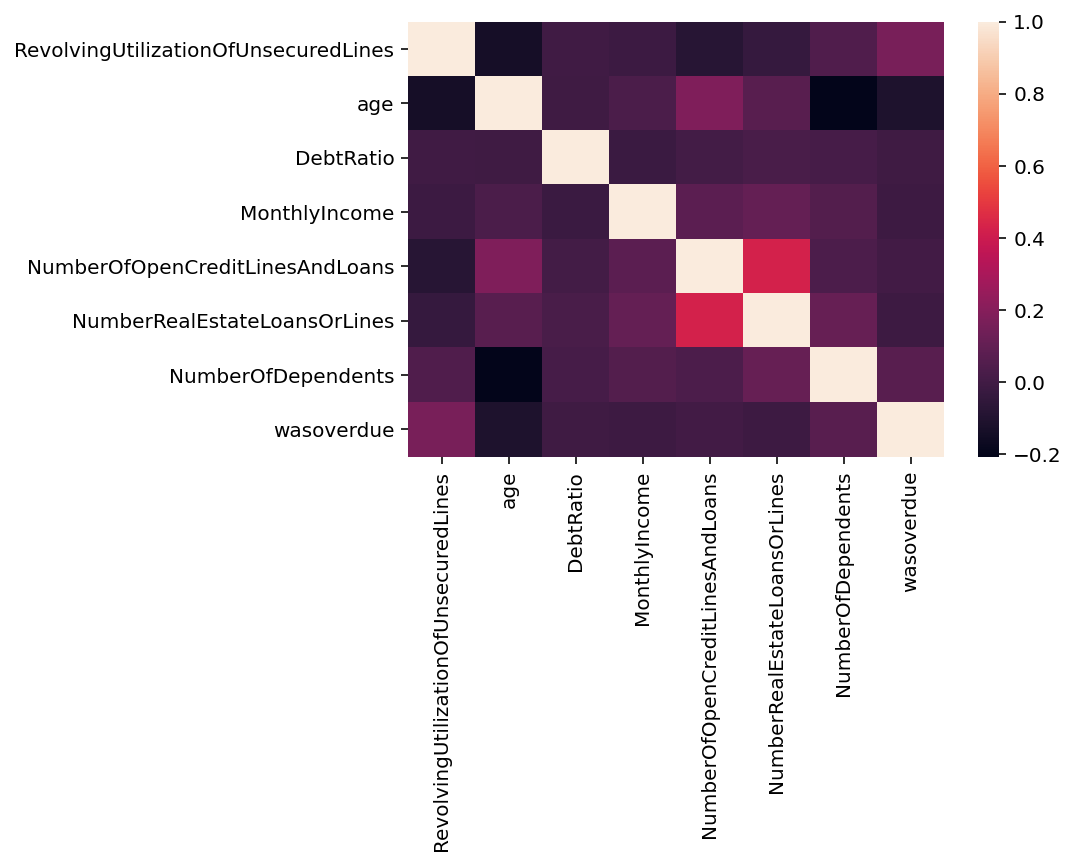

In [110]:
sns.heatmap(X_train.corr())

array([[<AxesSubplot:title={'center':'RevolvingUtilizationOfUnsecuredLines'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'DebtRatio'}>],
       [<AxesSubplot:title={'center':'MonthlyIncome'}>,
        <AxesSubplot:title={'center':'NumberOfOpenCreditLinesAndLoans'}>,
        <AxesSubplot:title={'center':'NumberRealEstateLoansOrLines'}>],
       [<AxesSubplot:title={'center':'NumberOfDependents'}>,
        <AxesSubplot:title={'center':'wasoverdue'}>, <AxesSubplot:>]],
      dtype=object)

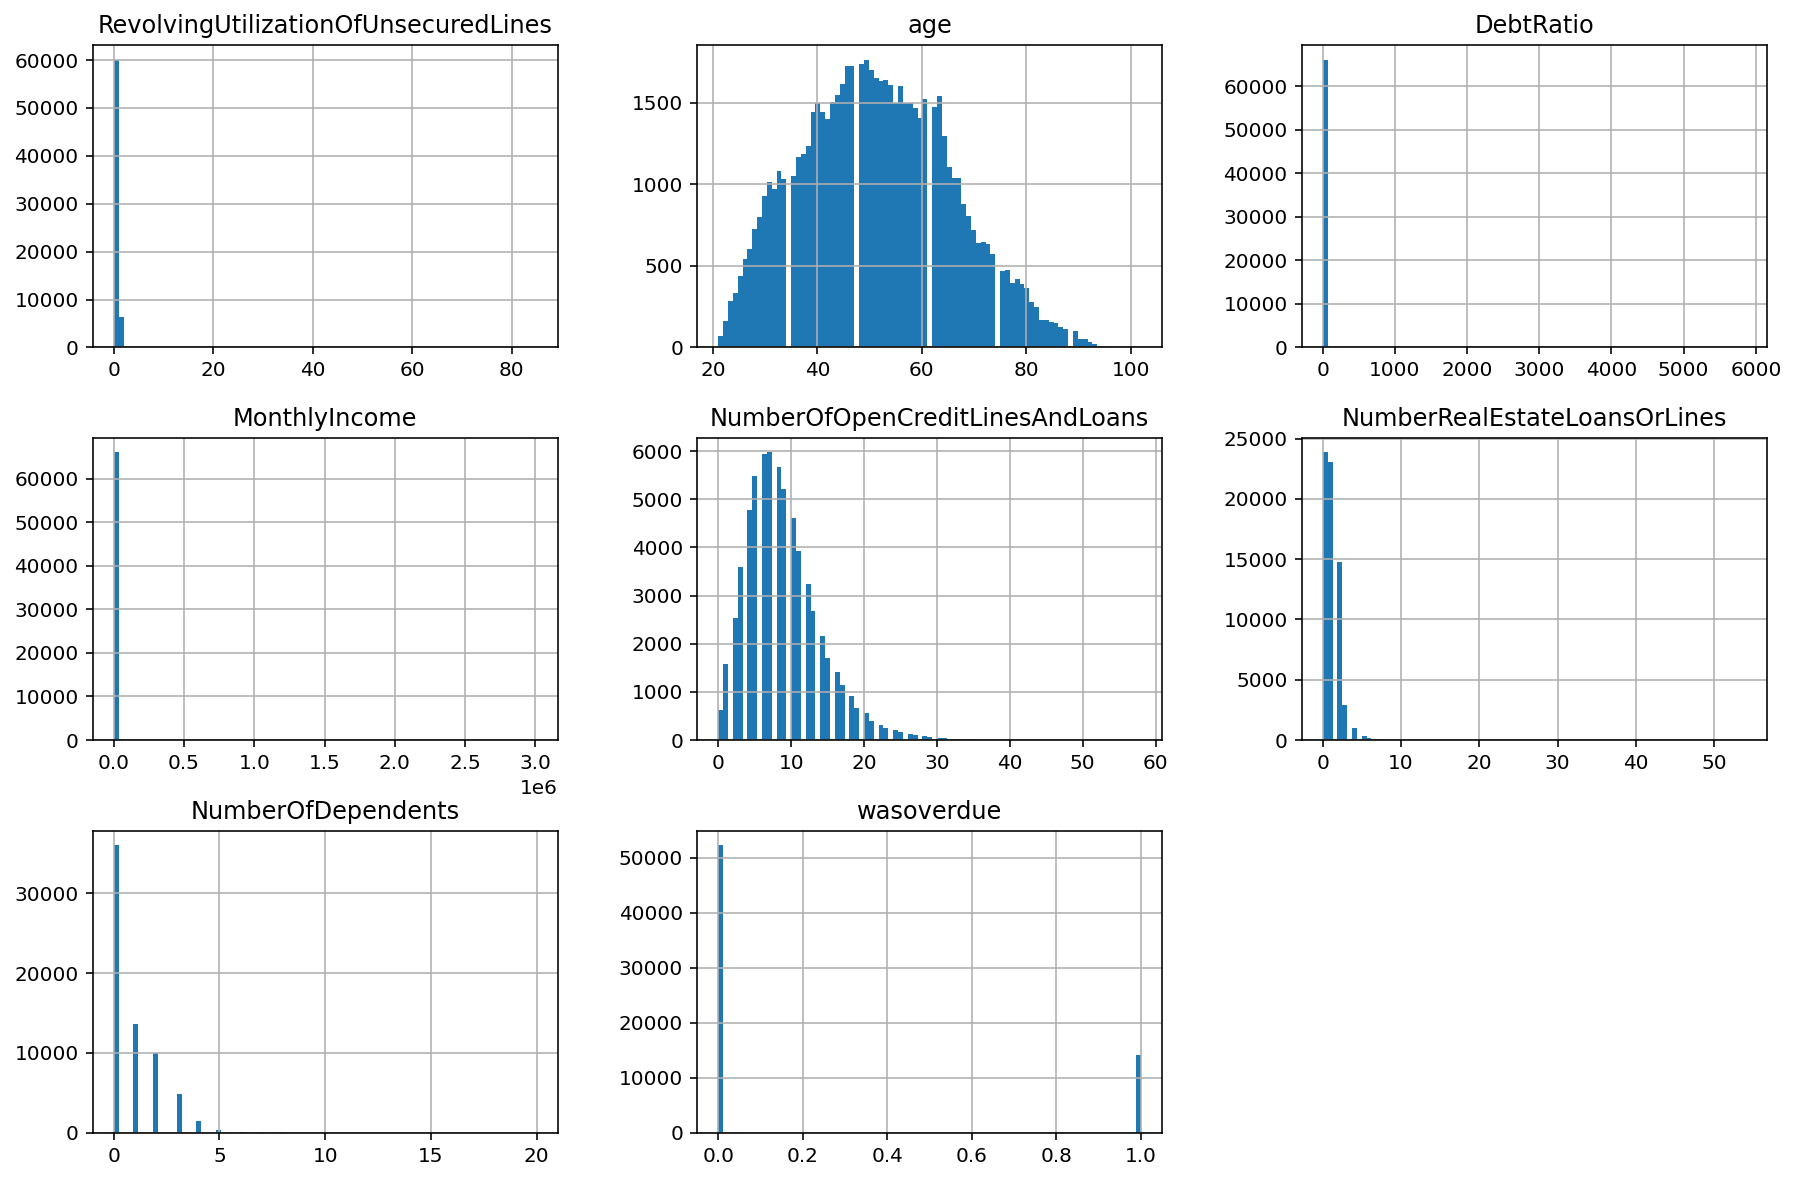

In [111]:
X_train.hist(bins=87, figsize=(15, 10))

In [112]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [113]:
X_train, y_train = KMeansSMOTE(cluster_balance_threshold = 0, random_state = rs).fit_resample(X_train, y_train)

In [114]:
def fit_predict(lr):
    lr.fit(X_train, y_train)
    print("score on train: "+ str(lr.score(X_train, y_train)))
    print("score on test: " + str(lr.score(X_test, y_test)))
    print(classification_report(y_test, lr.predict(X_test)))
    if hasattr(lr, 'best_params_'):
      print(lr.best_params_)

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
#lr = GridSearchCV(LogisticRegression(max_iter=10000),
#                    scoring='f1_weighted',
#                    cv=3,
#                  param_grid = {
#                      'C': [0.001, 1],
#                      'solver': ['newton-cg', 'sag', 'saga', 'liblinear', 'lbfgs']
#                  })
#fit_predict(lr)

In [117]:
lr = LogisticRegression(C = 1, solver = 'liblinear')
fit_predict(lr)

score on train: 0.90615937920197
score on test: 0.8562302562302563
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     26515
           1       0.20      0.36      0.26      1975

    accuracy                           0.86     28490
   macro avg       0.57      0.63      0.59     28490
weighted avg       0.90      0.86      0.87     28490



In [118]:
from sklearn.neighbors import KNeighborsClassifier

In [138]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)
fit_predict(knn)

score on train: 0.9605602086607158
score on test: 0.8957879957879958
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     26515
           1       0.27      0.30      0.28      1975

    accuracy                           0.90     28490
   macro avg       0.61      0.62      0.61     28490
weighted avg       0.90      0.90      0.90     28490



In [120]:
from sklearn.svm import LinearSVC

In [127]:
svc = LinearSVC(C = 0.001)
fit_predict(svc)

score on train: 0.899079819203914
score on test: 0.842049842049842
              precision    recall  f1-score   support

           0       0.95      0.88      0.91     26515
           1       0.17      0.34      0.23      1975

    accuracy                           0.84     28490
   macro avg       0.56      0.61      0.57     28490
weighted avg       0.89      0.84      0.86     28490



In [128]:
from sklearn.tree import DecisionTreeClassifier

In [130]:
dt = DecisionTreeClassifier(random_state=rs)
fit_predict(dt)

score on train: 0.9999837996338717
score on test: 0.8780624780624781
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     26515
           1       0.21      0.28      0.24      1975

    accuracy                           0.88     28490
   macro avg       0.58      0.60      0.59     28490
weighted avg       0.89      0.88      0.89     28490



In [131]:
from sklearn.ensemble import BaggingClassifier

In [147]:
bg = BaggingClassifier(DecisionTreeClassifier(random_state=rs),max_samples=0.5,max_features=0.5,n_estimators=100,random_state=rs)
fit_predict(bg)

score on train: 0.9840831402789703
score on test: 0.9284661284661284
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     26515
           1       0.38      0.05      0.09      1975

    accuracy                           0.93     28490
   macro avg       0.66      0.52      0.53     28490
weighted avg       0.90      0.93      0.90     28490



In [ ]:
bg_knn = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5,max_features=1,n_estimators=100,random_state=rs)
fit_predict(bg_knn)

In [137]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
fit_predict(adb)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
fit_predict(rf)